### Importing Libraries

In [ ]:
!pip install optuna tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

# import os
import math
import gc

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.12/dist-packages/cudf/utils/gpu_utils.py:75: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


### Some Constant

In [ ]:
# N_list = [12, 24, 48, 96, 192, 672]
N_list = [12, 24, 48]
points_prior_list = [4, 96, 672]
filenames = ["trans_1.csv", "trans_2.csv"]
TARGET_COL = "OT"
N_TRIALS = 10
GROUP_SIZE    = 96 * 7  # contiguous rows per group (e.g., 1 week for hourly data)
PROPORTIONS   = (0.70, 0.10, 0.20)  # train, val, test by groups
RANDOM_SEED   = 42     # shuffle groups reproducibly

### Preprocess Data

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

def make_sequences(X_scaled, y, N, points_prior):
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - N - points_prior + 1):
        X_seq.append(X_scaled[i:i+N, :])
        y_seq.append(y[i+N+points_prior-1])
    return np.array(X_seq), np.array(y_seq)

def preprocess_data(filename, N, points_prior):
    df = pd.read_csv(filename)

    # --- Create time features ---
    df["date"] = pd.to_datetime(df["date"])
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["dow"] = df["date"].dt.day_of_week
    df["hour"] = df["date"].dt.hour
    df["minute"] = df["date"].dt.minute
    df = df.drop(columns="date")

    # --- Separate target and features ---
    target = df["OT"].values
    features = df.drop(columns=["OT"]).values

    # --- Split ---
    train_size = int(len(df) * 0.7)
    val_size = int(len(df) * 0.1)
    X_train, X_val, X_test = np.split(features, [train_size, train_size + val_size])
    y_train, y_val, y_test = np.split(target, [train_size, train_size + val_size])

    X_final_train, X_final_test = np.split(features, [train_size + val_size])
    y_final_train, y_final_test = np.split(target, [train_size + val_size])

    # --- Scale ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    final_scaler = StandardScaler()
    X_final_train = final_scaler.fit_transform(X_final_train)
    X_final_test = final_scaler.transform(X_final_test)

    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1)).flatten()
    y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

    final_y_scaler = StandardScaler()
    y_final_train = final_y_scaler.fit_transform(y_final_train.reshape(-1, 1)).flatten()
    y_final_test = final_y_scaler.transform(y_final_test.reshape(-1, 1)).flatten()

    # --- Create sequences ---
    X_train_seq, y_train_seq = make_sequences(X_train_scaled, y_train_scaled, N, points_prior)
    X_val_seq, y_val_seq = make_sequences(X_val_scaled, y_val_scaled, N, points_prior)
    X_test_seq, y_test_seq = make_sequences(X_test_scaled, y_test_scaled, N, points_prior)
    X_final_train, y_final_train = make_sequences(X_final_train, y_final_train, N, points_prior)
    X_final_test, y_final_test = make_sequences(X_final_test, y_final_test, N, points_prior)

    return (
        (X_train_seq, y_train_seq),
        (X_val_seq, y_val_seq),
        (X_test_seq, y_test_seq),
        scaler,
        y_scaler,
        (X_final_train, y_final_train),
        (X_final_test, y_final_test),
        final_scaler,
        final_y_scaler
    )


In [ ]:
(X_train_seq, y_train_seq), (X_val_seq, y_val_seq), (X_test_seq, y_test_seq), scaler, y_scaler, (X_final_train, y_final_train), (X_final_test, y_final_test), final_scaler, final_y_scaler = preprocess_data(df_filenames[0], N_list[0], points_prior_list[0])

Hyperparameter Tuning

In [ ]:
import itertools
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

def hyperparameter_tuning(X_train_seq, X_val_seq, y_train_seq, y_val_seq):
  # ====== CONFIGURABLE HYPERPARAMETERS ======
  epochs_list = [20, 50]
  batch_sizes = [8, 64]
  num_layers_list = [1, 2]        # how many SimpleRNN layers to use
  units_list = [32, 64]           # number of units in each RNN layer
  dropouts = [0.2, 0.3]

  results = []  # to store performance results

  # ====== TRAINING LOOP ======
  for epochs, batch_size, num_layers, units, dropout_rate in itertools.product(
      epochs_list, batch_sizes, num_layers_list, units_list, dropouts
  ):
      print(f"\nTraining with: epochs={epochs}, batch_size={batch_size}, "
            f"layers={num_layers}, units={units}, dropout={dropout_rate}")

      # Build model dynamically based on num_layers
      model = Sequential()

      # Add RNN layers
      for i in range(num_layers):
          # Only last layer should not return sequences
          return_seq = (i < num_layers - 1)
          model.add(SimpleRNN(
              units=units,
              activation='relu',
              return_sequences=return_seq
          ))
          model.add(Dropout(dropout_rate))

      # Dense layers
      model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
      model.add(Dense(1))

      # Compile
      model.compile(optimizer='adam', loss='mean_squared_error')

      # Early stopping
      es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

      # Train
      history = model.fit(
          X_train_seq, y_train_seq,
          validation_data=(X_val_seq, y_val_seq),
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[es],
          verbose=0
      )

      # Record best val_loss
      val_loss = min(history.history['val_loss'])
      print(f"✅ Best val_loss: {val_loss:.6f}")

      results.append({
          'epochs': epochs,
          'batch_size': batch_size,
          'num_layers': num_layers,
          'units': units,
          'dropout': dropout_rate,
          'val_loss': val_loss
      })

  # ====== SAVE RESULTS ======
  results_df = pd.DataFrame(results)
  results_df = results_df.sort_values(by='val_loss', ascending=True)
  # results_df.to_csv("rnn_results.csv", index=False)

  print("\n=== Best Configurations ===")
  print(results_df.head())

  return results_df

In [ ]:
# results_df = hyperparameter_tuning(X_train_seq, X_val_seq, y_train_seq, y_val_seq)

# Training with: epochs=20, batch_size=8, layers=1, units=32, dropout=0.2
# ✅ Best val_loss: 0.287031

# Training with: epochs=20, batch_size=8, layers=1, units=32, dropout=0.3
# ✅ Best val_loss: 0.508984

# Training with: epochs=20, batch_size=8, layers=1, units=64, dropout=0.2
# ✅ Best val_loss: 0.514605

# Training with: epochs=20, batch_size=8, layers=1, units=64, dropout=0.3
# ✅ Best val_loss: 0.244680

# Training with: epochs=20, batch_size=8, layers=2, units=32, dropout=0.2
# ✅ Best val_loss: 0.506266

# Training with: epochs=20, batch_size=8, layers=2, units=32, dropout=0.3
# ✅ Best val_loss: 0.419856

# Training with: epochs=20, batch_size=8, layers=2, units=64, dropout=0.2
# ✅ Best val_loss: 0.519545

# Training with: epochs=20, batch_size=8, layers=2, units=64, dropout=0.3
# ✅ Best val_loss: 0.291996

# Training with: epochs=20, batch_size=64, layers=1, units=32, dropout=0.2
# ✅ Best val_loss: 0.271420

# Training with: epochs=20, batch_size=64, layers=1, units=32, dropout=0.3
# ✅ Best val_loss: 0.311232

# Training with: epochs=20, batch_size=64, layers=1, units=64, dropout=0.2
# ✅ Best val_loss: 0.171733

# Training with: epochs=20, batch_size=64, layers=1, units=64, dropout=0.3
# ✅ Best val_loss: 0.291942

# Training with: epochs=20, batch_size=64, layers=2, units=32, dropout=0.2
# ✅ Best val_loss: 0.536075

# Training with: epochs=20, batch_size=64, layers=2, units=32, dropout=0.3
# ✅ Best val_loss: 0.411607

# Training with: epochs=20, batch_size=64, layers=2, units=64, dropout=0.2
# ✅ Best val_loss: 0.437644

# Training with: epochs=20, batch_size=64, layers=2, units=64, dropout=0.3
# ✅ Best val_loss: 0.645080

# Training with: epochs=50, batch_size=8, layers=1, units=32, dropout=0.2

Training

In [ ]:
for filename in filenames:
  for points_prior in points_prior_list:
    print(f"\n========================================================")
    print(f"Processing: File={filename}, PointsPrior={points_prior}, Model=RNN")
    print(f"========================================================\n")

    results_per_n = {}

    for N in N_list:
      (X_train_seq, y_train_seq), (X_val_seq, y_val_seq), (X_test_seq, y_test_seq), scaler, y_scaler, (X_final_train, y_final_train), (X_final_test, y_final_test), final_scaler, final_y_scaler = preprocess_data(filename, N, points_prior)

      ### RNN Model
      model = Sequential()
      model.add(SimpleRNN(
          units=64,
          activation='relu',
          return_sequences=False
      ))
      model.add(Dropout(0.2))

      model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
      model.add(Dense(1))

      model.compile(optimizer='adam', loss='mean_squared_error')

      ### Fitting the model
      history = model.fit(
          X_final_train, y_final_train,
          epochs=20,
          batch_size=64,
          verbose=1
      )

      ### Predictions
      predictions = model.predict(X_final_test)
      predictions = predictions.flatten()

      mse = mean_squared_error(final_y_scaler.inverse_transform(y_final_test.reshape(-1, 1)), final_y_scaler.inverse_transform(predictions.reshape(-1, 1)))
      rmse = np.sqrt(mse)
      mae = mean_absolute_error(final_y_scaler.inverse_transform(y_final_test.reshape(-1, 1)), final_y_scaler.inverse_transform(predictions.reshape(-1, 1)))

      print(f"\nMetrics For N:{N}, points_prior: {points_prior}, filename: {filename}")
      print(f"Mean Squared Error (MSE): {mse:.4f}")
      print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
      print(f"Mean Absolute Error (MAE): {mae:.4f}")

      results_per_n[N] = {
          "rmse": rmse,
          "model" : model
      }

    best_n_value = min(results_per_n.keys(), key=lambda n: results_per_n[n]["rmse"])
    best_result = results_per_n[best_n_value]
    model = best_result["model"]

    model_filename = f"RNN_ N_{best_n_value} points_prior_{points_prior} dataset_{filename[:-4]}.h5"
    model.save(model_filename)

    print(f"Model saved to {model_filename}")

    print(f"\n--------------------------------------------------------")
    print(f"*** BEST N for {filename}, points_prior: {points_prior}, Model RNN ***")
    print(f"Best N: \t\t{best_n_value}")
    print(f"Best Test RMSE: \t{best_result['rmse']:.4f}")
    print(f"--------------------------------------------------------\n")


Processing: File=trans_1.csv, PointsPrior=4, Model=RNN

Epoch 1/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.4237
Epoch 2/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.1217
Epoch 3/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1026
Epoch 4/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0891
Epoch 5/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0784
Epoch 6/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0700
Epoch 7/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0641
Epoch 8/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0599
Epoch 9/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0568
Epoch 10/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0528
Epoch 11/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0517
Epoch 12/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0481
Epoch 13/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0492
Epoch 14/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0443



Metrics For N:48, points_prior: 4, filename: trans_1.csv
Mean Squared Error (MSE): 11.7179
Root Mean Squared Error (RMSE): 3.4231
Mean Absolute Error (MAE): 2.7210
Model saved to RNN_ N_24 points_prior_4 dataset_trans_1.h5

--------------------------------------------------------
*** BEST N for trans_1.csv, points_prior: 4, Model RNN ***
Best N: 		24
Best Test RMSE: 	2.9893
--------------------------------------------------------


Processing: File=trans_1.csv, PointsPrior=96, Model=RNN

Epoch 1/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.3801
Epoch 2/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.1312
Epoch 3/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1084
Epoch 4/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0925
Epoch 5/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0804
Epoch 6/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0706
Epoch 7/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0645
Epoch 8/20
870/870 ━━━━━━━━━━━━━━━━━━


Metrics For N:48, points_prior: 96, filename: trans_1.csv
Mean Squared Error (MSE): 11.3524
Root Mean Squared Error (RMSE): 3.3693
Mean Absolute Error (MAE): 2.7106
Model saved to RNN_ N_48 points_prior_96 dataset_trans_1.h5

--------------------------------------------------------
*** BEST N for trans_1.csv, points_prior: 96, Model RNN ***
Best N: 		48
Best Test RMSE: 	3.3693
--------------------------------------------------------


Processing: File=trans_1.csv, PointsPrior=672, Model=RNN

Epoch 1/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.4870
Epoch 2/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1402
Epoch 3/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.1171
Epoch 4/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1007
Epoch 5/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0855
Epoch 6/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0750
Epoch 7/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0627
Epoch 8/20
861/861 ━━━━━━━━━━━━━


Metrics For N:48, points_prior: 672, filename: trans_1.csv
Mean Squared Error (MSE): 16.9784
Root Mean Squared Error (RMSE): 4.1205
Mean Absolute Error (MAE): 3.3682
Model saved to RNN_ N_48 points_prior_672 dataset_trans_1.h5

--------------------------------------------------------
*** BEST N for trans_1.csv, points_prior: 672, Model RNN ***
Best N: 		48
Best Test RMSE: 	4.1205
--------------------------------------------------------


Processing: File=trans_2.csv, PointsPrior=4, Model=RNN

Epoch 1/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.3940
Epoch 2/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1276
Epoch 3/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0992
Epoch 4/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0821
Epoch 5/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0719
Epoch 6/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0659
Epoch 7/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0601
Epoch 8/20
871/871 ━━━━━━━━━━━━━


Metrics For N:48, points_prior: 4, filename: trans_2.csv
Mean Squared Error (MSE): 104.1912
Root Mean Squared Error (RMSE): 10.2074
Mean Absolute Error (MAE): 7.9463
Model saved to RNN_ N_12 points_prior_4 dataset_trans_2.h5

--------------------------------------------------------
*** BEST N for trans_2.csv, points_prior: 4, Model RNN ***
Best N: 		12
Best Test RMSE: 	7.1798
--------------------------------------------------------


Processing: File=trans_2.csv, PointsPrior=96, Model=RNN

Epoch 1/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.4271
Epoch 2/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1538
Epoch 3/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.1215
Epoch 4/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1047
Epoch 5/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0918
Epoch 6/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0833
Epoch 7/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0727
Epoch 8/20
870/870 ━━━━━━━━━━━━━━━━


Metrics For N:48, points_prior: 96, filename: trans_2.csv
Mean Squared Error (MSE): 59.5003
Root Mean Squared Error (RMSE): 7.7136
Mean Absolute Error (MAE): 6.3692
Model saved to RNN_ N_12 points_prior_96 dataset_trans_2.h5

--------------------------------------------------------
*** BEST N for trans_2.csv, points_prior: 96, Model RNN ***
Best N: 		12
Best Test RMSE: 	7.3623
--------------------------------------------------------


Processing: File=trans_2.csv, PointsPrior=672, Model=RNN

Epoch 1/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.4810
Epoch 2/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1594
Epoch 3/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.1240
Epoch 4/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1054
Epoch 5/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0915
Epoch 6/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0788
Epoch 7/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0717
Epoch 8/20
861/861 ━━━━━━━━━━━━━━


Metrics For N:48, points_prior: 672, filename: trans_2.csv
Mean Squared Error (MSE): 94.5088
Root Mean Squared Error (RMSE): 9.7216
Mean Absolute Error (MAE): 7.6377
Model saved to RNN_ N_12 points_prior_672 dataset_trans_2.h5

--------------------------------------------------------
*** BEST N for trans_2.csv, points_prior: 672, Model RNN ***
Best N: 		12
Best Test RMSE: 	7.6517
--------------------------------------------------------



In [ ]:
# Training with: epochs=20, batch_size=64, layers=1, units=64, dropout=0.2
# ✅ Best val_loss: 0.171733

model = Sequential()
model.add(SimpleRNN(
    units=64,
    activation='relu',
    return_sequences=False
))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_final_train, y_final_train,
    # validation_data=(X_final_test, y_final_test),
    epochs=20,
    batch_size=64,
    # callbacks=[es],
    verbose=1
)

Epoch 1/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3760
Epoch 2/20
 50/871 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1213

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


871/871 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1216
Epoch 3/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0994
Epoch 4/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0885
Epoch 5/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0773
Epoch 6/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0694
Epoch 7/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0623
Epoch 8/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0577
Epoch 9/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0550
Epoch 10/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0509
Epoch 11/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0495
Epoch 12/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0454
Epoch 13/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0425
Epoch 14/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0420
Epoch 15/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0401
Epoch 16/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0384

In [ ]:
predictions = model.predict(X_final_test)
predictions = predictions.flatten()

# mse = mean_squared_error((y_test_seq), (predictions))
# rmse = np.sqrt(mse)
# mae = mean_absolute_error((y_test_seq), predictions)

mse = mean_squared_error(final_y_scaler.inverse_transform(y_final_test.reshape(-1, 1)), final_y_scaler.inverse_transform(predictions.reshape(-1, 1)))
rmse = np.sqrt(mse)
mae = mean_absolute_error(final_y_scaler.inverse_transform(y_final_test.reshape(-1, 1)), final_y_scaler.inverse_transform(predictions.reshape(-1, 1)))


print(f"\nMetrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

436/436 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Metrics:
Mean Squared Error (MSE): 13.5605
Root Mean Squared Error (RMSE): 3.6825
Mean Absolute Error (MAE): 2.8075


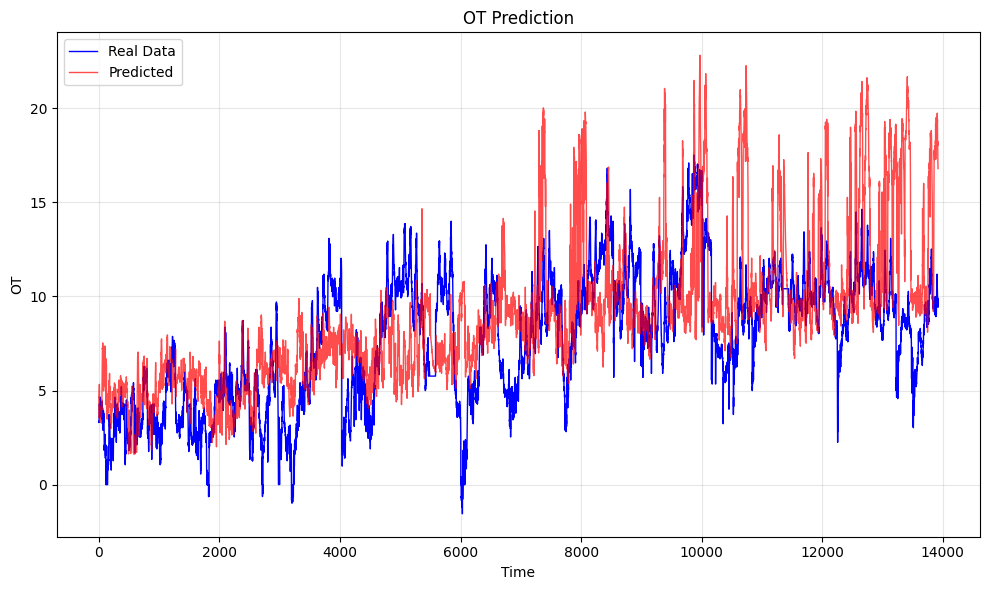

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(final_y_scaler.inverse_transform(y_final_test.reshape(-1, 1)), color='blue', label='Real Data', linewidth=1)
plt.plot(final_y_scaler.inverse_transform(predictions.reshape(-1, 1)), color='red', label='Predicted', linewidth=1, alpha=0.7)
plt.title('OT Prediction')
plt.xlabel('Time')
plt.ylabel('OT')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
predictions = model.predict(X_val_seq)
predictions = predictions.flatten()

# mse = mean_squared_error((y_val_seq), (predictions))
# rmse = np.sqrt(mse)
# mae = mean_absolute_error((y_val_seq), (predictions))

mse = mean_squared_error(y_scaler.inverse_transform(y_val_seq.reshape(-1, 1)), y_scaler.inverse_transform(predictions.reshape(-1, 1)))
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_scaler.inverse_transform(y_val_seq.reshape(-1, 1)), y_scaler.inverse_transform(predictions.reshape(-1, 1)))


print(f"\nMetrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Metrics:
Mean Squared Error (MSE): 8.2475
Root Mean Squared Error (RMSE): 2.8718
Mean Absolute Error (MAE): 2.3167


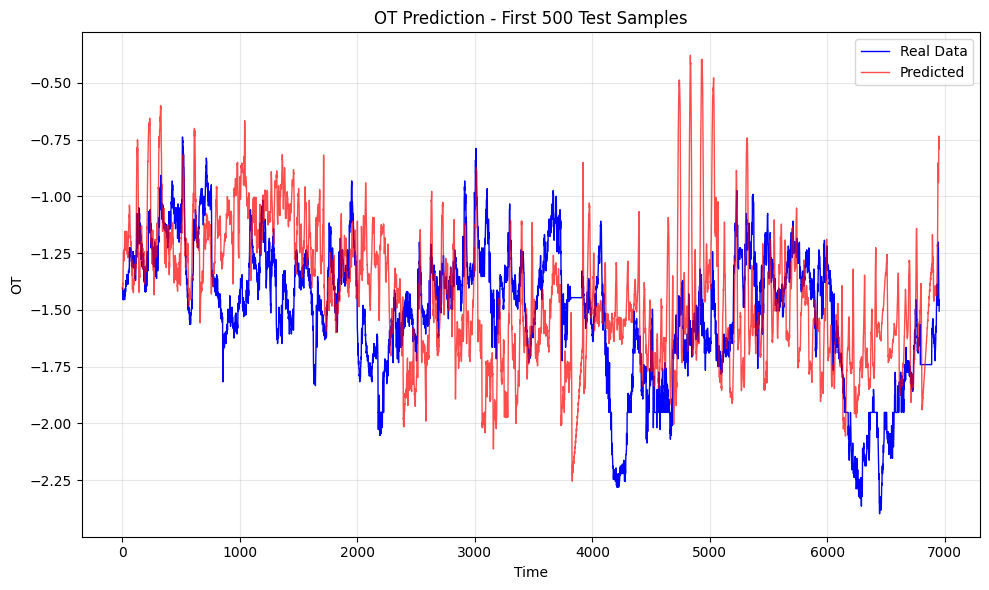

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_val_seq, color='blue', label='Real Data', linewidth=1)
plt.plot(predictions, color='red', label='Predicted', linewidth=1, alpha=0.7)
plt.title('OT Prediction - First 500 Test Samples')
plt.xlabel('Time')
plt.ylabel('OT')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
predictions = model.predict(X_train_seq)
predictions = predictions.flatten()

# mse = mean_squared_error((y_train_seq), (predictions))
# rmse = np.sqrt(mse)
# mae = mean_absolute_error((y_train_seq), (predictions))

mse = mean_squared_error(y_scaler.inverse_transform(y_train_seq.reshape(-1, 1)), y_scaler.inverse_transform(predictions.reshape(-1, 1)))
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_scaler.inverse_transform(y_train_seq.reshape(-1, 1)), y_scaler.inverse_transform(predictions.reshape(-1, 1)))


print(f"\nMetrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

1524/1524 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Metrics:
Mean Squared Error (MSE): 6.5554
Root Mean Squared Error (RMSE): 2.5604
Mean Absolute Error (MAE): 1.9442


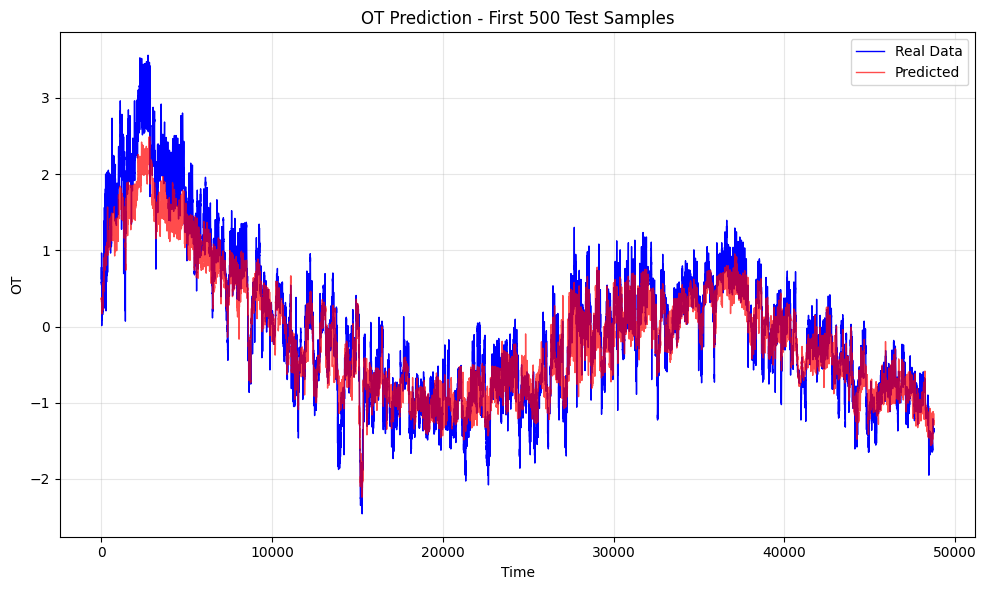

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_train_seq, color='blue', label='Real Data', linewidth=1)
plt.plot(predictions, color='red', label='Predicted', linewidth=1, alpha=0.7)
plt.title('OT Prediction - First 500 Test Samples')
plt.xlabel('Time')
plt.ylabel('OT')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
predictions = model.predict(X_final_train)
predictions = predictions.flatten()

# mse = mean_squared_error((y_train_seq), (predictions))
# rmse = np.sqrt(mse)
# mae = mean_absolute_error((y_train_seq), (predictions))

mse = mean_squared_error(final_y_scaler.inverse_transform(y_final_train.reshape(-1, 1)), final_y_scaler.inverse_transform(predictions.reshape(-1, 1)))
rmse = np.sqrt(mse)
mae = mean_absolute_error(final_y_scaler.inverse_transform(y_final_train.reshape(-1, 1)), final_y_scaler.inverse_transform(predictions.reshape(-1, 1)))


print(f"\nMetrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

1742/1742 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Metrics:
Mean Squared Error (MSE): 3.7133
Root Mean Squared Error (RMSE): 1.9270
Mean Absolute Error (MAE): 1.4918


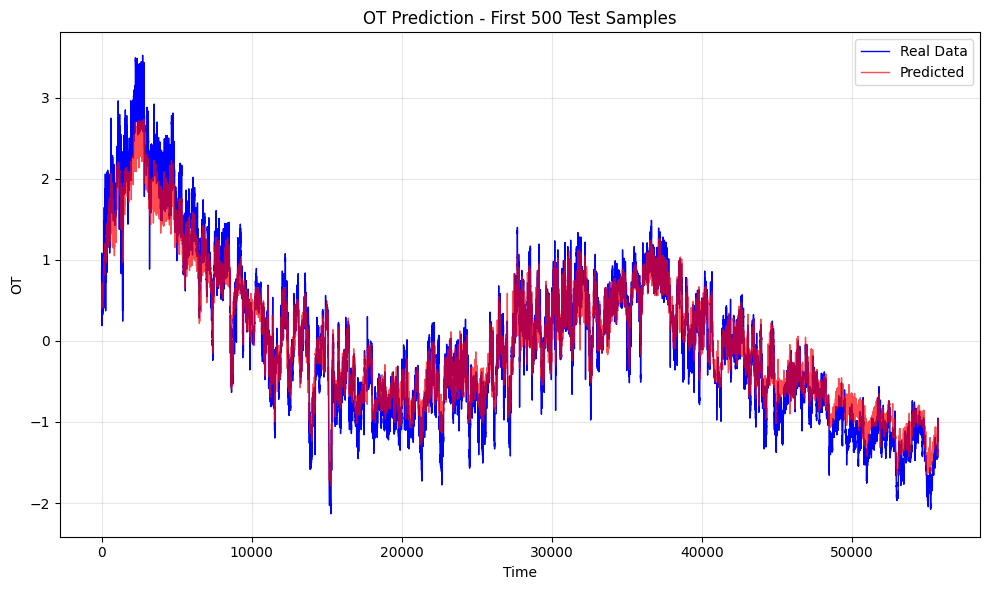

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_final_train, color='blue', label='Real Data', linewidth=1)
plt.plot(predictions, color='red', label='Predicted', linewidth=1, alpha=0.7)
plt.title('OT Prediction - First 500 Test Samples')
plt.xlabel('Time')
plt.ylabel('OT')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()